### The Kelly Rule - Size Positions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pytz
from datetime import datetime as dt
from histData import binance_bars
from utils.tools import to_utc, multiJoin, multiDF
from utils.flow import Kalman
from tqdm.notebook import tqdm, trange
import timeit

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
import pyximport
# pyximport.install()
pyximport.install(setup_args={"script_args" : ["--verbose"],
                              "include_dirs":np.get_include()},
                  reload_support=True, )
%load_ext cython

In [5]:
from cyutils.cyzers import apply_kelly1, apply_kelly, apply_kelly_prog, ll_single_kelly, ll_norm_integral, minimize_scalar_bounded 

In [6]:
# from numpy import sqrt

### Single Asset | BTCUSDT 1m

In [81]:
tickers=['BTCUSDT']
interval='1d'  # '1m'
start_dt='2019-01-01'
end_dt=None
vol_window=60

start_dt = to_utc(start_dt)
print ("START DATE:", start_dt)
end_dt = pytz.utc.localize(dt.utcnow()) if not end_dt else to_utc(end_dt)
print("END DATE:", end_dt)
print("TICKERS:", tickers)
print("INTERVAL:", interval)

Assuming naive datetime: 2019-01-01 00:00:00 is already in UTC and labelling it as such. Ensure this is correct.
START DATE: 2019-01-01 00:00:00+00:00
END DATE: 2022-06-23 16:46:14.233901+00:00
TICKERS: ['BTCUSDT']
INTERVAL: 1d


In [82]:
csv_file = False
save_csv = False

In [83]:
sets = {}

if not csv_file:
    for ticker in tickers:
        df = binance_bars(symbol=ticker, interval=interval,
                            start_dt=start_dt, end_dt=end_dt, limit=None, dtype='df');
        sets[ticker] = df

else:
    for ticker in tickers:
        df = pd.read_csv('csv_files/BTCUSDT_2017-08-17_2022-05-01.csv',
                        low_memory=False, index_col=['DateTime'], parse_dates=['DateTime'], infer_datetime_format=True)
        sets[ticker] = df

df.tail()

(1270, 5)


,open,high,low,close,volume,time
DateTime,,,,,,
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.87595,2022-06-19 01:00:00+00:00
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.94154,2022-06-20 01:00:00+00:00
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.07490,2022-06-21 01:00:00+00:00
2022-06-22 01:00:00+00:00,20723.51,20900.00,19770.51,19987.99,92133.97938,2022-06-22 01:00:00+00:00
2022-06-23 01:00:00+00:00,19988.00,20829.21,19890.07,20315.02,56479.49054,2022-06-23 01:00:00+00:00


In [84]:
# df.info()

In [85]:
if not csv_file:
    df['Price_Returns'] = df['close'].pct_change()
df['Std_60'] = df['Price_Returns'].rolling(vol_window).agg(['std'])
df['SMA_60'] = df['Price_Returns'].rolling(vol_window).agg(['mean'])

In [86]:
if interval == '1m':
    af = 365*24*60

    df['SMA_60'] = round(((1 + df['SMA_60'])**af)-1, 4)
    df['Std_60'] = round(df['Std_60']*np.sqrt(af), 4)

In [87]:
# test_start = '2021-05-23 19:19:00+00:00'
# test_start = '2022-05-01 08:00:00+00:00'
# test_start = df.index[-1440]
test_start = df.index[0]

df1 = df.loc[test_start:]
len(df1)

1270

In [88]:
df1

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60
DateTime,,,,,,,,,
2019-01-01 00:00:00+00:00,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 00:00:00+00:00,NaN,NaN,NaN
2019-01-02 00:00:00+00:00,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 00:00:00+00:00,0.016175,NaN,NaN
2019-01-03 00:00:00+00:00,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 00:00:00+00:00,-0.023786,NaN,NaN
2019-01-04 00:00:00+00:00,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 00:00:00+00:00,0.006698,NaN,NaN
2019-01-05 00:00:00+00:00,3790.09,3840.99,3751.00,3770.96,30490.667751,2019-01-05 00:00:00+00:00,-0.005551,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.875950,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.941540,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.074900,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799


In [89]:
df1['SMA_60'].describe()

count    1210.000000
mean        0.002511
std         0.005699
min        -0.012054
25%        -0.001763
50%         0.002656
75%         0.006290
max         0.017147
Name: SMA_60, dtype: float64

In [31]:
# %%timeit -r 10
# df1['f'] = apply_kelly1(df1['SMA_60'].to_numpy(), df1['Std_60'].to_numpy(), bounds=np.array([0., 2.]))

In [32]:
# %%timeit -r 10
# df1['f'] = apply_kelly(df1['SMA_60'].to_numpy(), df1['Std_60'].to_numpy(), bounds=np.array([0., 2.]))

In [33]:
m = 0.001463
s = 0.034792

In [34]:
# %%timeit -r 5
x = minimize_scalar_bounded(ll_norm_integral, args=(m, s), bounds=np.array([0., 2.]))
x

1.2398457864215786

In [35]:
# %%timeit -r 5
sol = ll_single_kelly(m, s, bounds=np.array([0., 2.]))
sol

1.2398

In [36]:
df1

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60
DateTime,,,,,,,,,
2019-01-01 00:00:00+00:00,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 00:00:00+00:00,NaN,NaN,NaN
2019-01-02 00:00:00+00:00,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 00:00:00+00:00,0.016175,NaN,NaN
2019-01-03 00:00:00+00:00,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 00:00:00+00:00,-0.023786,NaN,NaN
2019-01-04 00:00:00+00:00,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 00:00:00+00:00,0.006698,NaN,NaN
2019-01-05 00:00:00+00:00,3790.09,3840.99,3751.00,3770.96,30490.667751,2019-01-05 00:00:00+00:00,-0.005551,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.875950,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.941540,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.074900,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799


#### Long only with 2x leverage

In [102]:
# Long only with 2x leverage
bounds = np.array([0., 2.])

pbar = 0
with tqdm(total=len(df1)) as pbar:
    df1['f'] = apply_kelly_prog(pbar, df1['SMA_60'].to_numpy(), df1['Std_60'].to_numpy(), bounds=bounds)

  0%|          | 0/1270 [00:00<?, ?it/s]

In [103]:
# %prun -l 4 df1['f'] = apply_kelly(df1['SMA_60'].to_numpy(), df1['Std_60_Min'].to_numpy())

In [104]:
df1.tail()

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60,f,kelly_returns,kelly_cum_returns,cum_returns
DateTime,,,,,,,,,,,,,
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.87595,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591,0.000004,-0.084509,7.304237,4.418289
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.94154,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237,0.000004,0.000005,7.304281,4.418260
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.07490,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799,0.000004,-0.007273,7.243886,4.457666
2022-06-22 01:00:00+00:00,20723.51,20900.00,19770.51,19987.99,92133.97938,2022-06-22 01:00:00+00:00,-0.035493,0.044048,-0.010278,0.000004,0.035492,7.536481,4.263959
2022-06-23 01:00:00+00:00,19988.00,20829.21,19890.07,20315.02,56479.49054,2022-06-23 01:00:00+00:00,0.016361,0.044162,-0.010009,0.000004,-0.016361,7.396814,4.350085


In [105]:
if save_csv:
    str_start = df1.index.min().strftime('%Y-%m-%d')
    str_end = df1.index.max().strftime('%Y-%m-%d')
    f_name = f'csv_files/kelly_{ticker}{interval}_{str_start}_{str_end}.csv'
    df1.to_csv(f_name)

Performance Evaluation

In [106]:
df1 = df1.assign(kelly_returns=df1['Price_Returns'].mul(df1['f'].shift()))
df1 = df1.assign(kelly_cum_returns=df1['kelly_returns'].iloc[0:].add(1).cumprod().sub(1))
df1 = df1.assign(cum_returns=df1['Price_Returns'].dropna().iloc[0:].add(1).cumprod().sub(1)) 

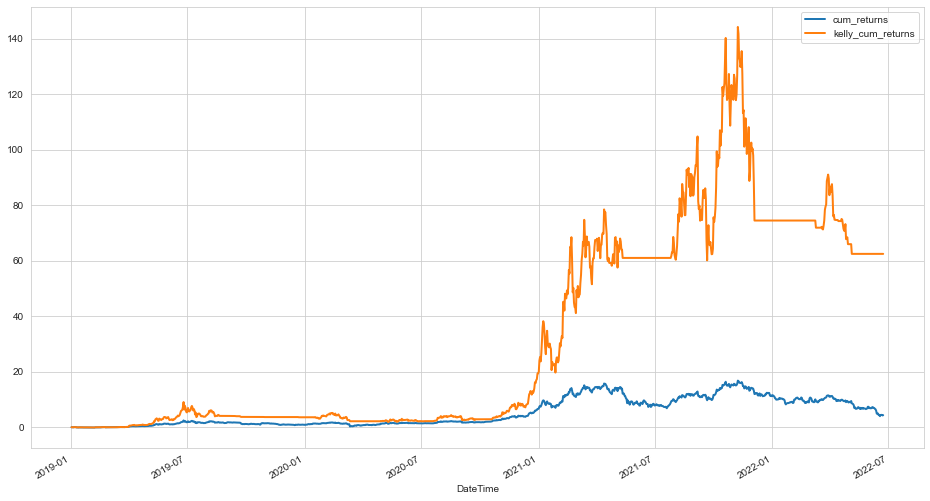

In [107]:
(df1[['cum_returns', 'kelly_cum_returns']].plot(lw=2, figsize=(16, 9)));

In [43]:
df1['f'].describe()

count    1270.000000
mean        1.114589
std         0.932063
min         0.000004
25%         0.000004
50%         1.692794
75%         1.999996
max         1.999996
Name: f, dtype: float64

#### Long/Short with 2x leverage

In [111]:
# Long/Short with 2x leverage
bounds = np.array([-2., 2.])

pbar = 0
with tqdm(total=len(df1)) as pbar:
    df1['f'] = apply_kelly_prog(pbar, df1['SMA_60'].to_numpy(), df1['Std_60'].to_numpy(), bounds=bounds)

  0%|          | 0/1270 [00:00<?, ?it/s]

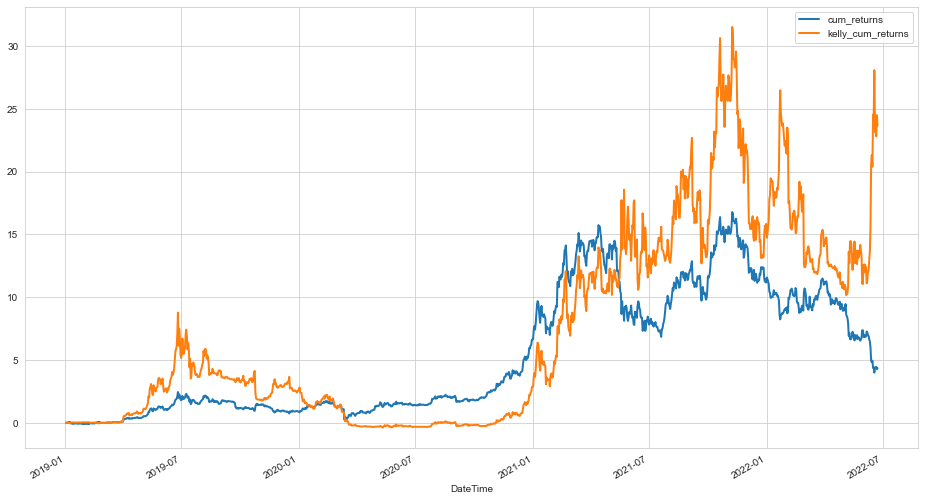

In [112]:
df1 = df1.assign(kelly_returns=df1['Price_Returns'].mul(df1['f'].shift()))
df1 = df1.assign(kelly_cum_returns=df1['kelly_returns'].iloc[0:].add(1).cumprod().sub(1))
df1 = df1.assign(cum_returns=df1['Price_Returns'].dropna().iloc[0:].add(1).cumprod().sub(1))
(df1[['cum_returns', 'kelly_cum_returns']].plot(lw=2, figsize=(16, 9)));

Compute Kelly Fraction

In [44]:
m = 0.001463
s = 0.034792

# m = 0.0003051062132086039
# s = 0.0006259370527022952

In [45]:
# Minimize the expectation integral
x = minimize_scalar_bounded(ll_norm_integral, args=(m, s), bounds=np.array([0., 2.]))
print('Optimal Kelly fraction: {:.4f}'.format(x))

Optimal Kelly fraction: 1.2398


#### Stream version

In [46]:
window = 60
df = df.iloc[window:]
df

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60
DateTime,,,,,,,,,
2019-03-02 00:00:00+00:00,3822.17,3841.31,3772.25,3819.93,19445.838355,2019-03-02 00:00:00+00:00,-0.000803,0.026616,0.000453
2019-03-03 00:00:00+00:00,3819.97,3835.00,3781.32,3807.75,16718.165410,2019-03-03 00:00:00+00:00,-0.003189,0.026540,0.000130
2019-03-04 00:00:00+00:00,3807.32,3830.00,3670.69,3715.30,34742.841660,2019-03-04 00:00:00+00:00,-0.024279,0.026547,0.000122
2019-03-05 00:00:00+00:00,3716.10,3877.10,3703.55,3857.73,32962.536162,2019-03-05 00:00:00+00:00,0.038336,0.026991,0.000649
2019-03-06 00:00:00+00:00,3857.58,3907.00,3813.09,3861.84,24775.118830,2019-03-06 00:00:00+00:00,0.001065,0.026978,0.000760
...,...,...,...,...,...,...,...,...,...
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.875950,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.941540,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.074900,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799


In [49]:
df['f'] = pd.Series()
for idx, col in df.iterrows():
    m = df['SMA_60'].loc[idx]
    s = df['Std_60'].loc[idx]
    # df['f'].loc[idx] = newton(norm_dev_integral, .1, args=(m, s))
    sol = ll_single_kelly(m, s, bounds=np.array([0., 2.]))
    df['f'].loc[idx] = sol

In [ ]:
# df['frac'] = df['f'] * 0.33
df

In [50]:
df = df.assign(kelly_returns=df['Price_Returns'].mul(df['f'].shift()))
df = df.assign(strat_cum_returns=df['kelly_returns'].iloc[0:].add(1).cumprod().sub(1))
df = df.assign(cum_returns=df['Price_Returns'].dropna().iloc[0:].add(1).cumprod().sub(1))

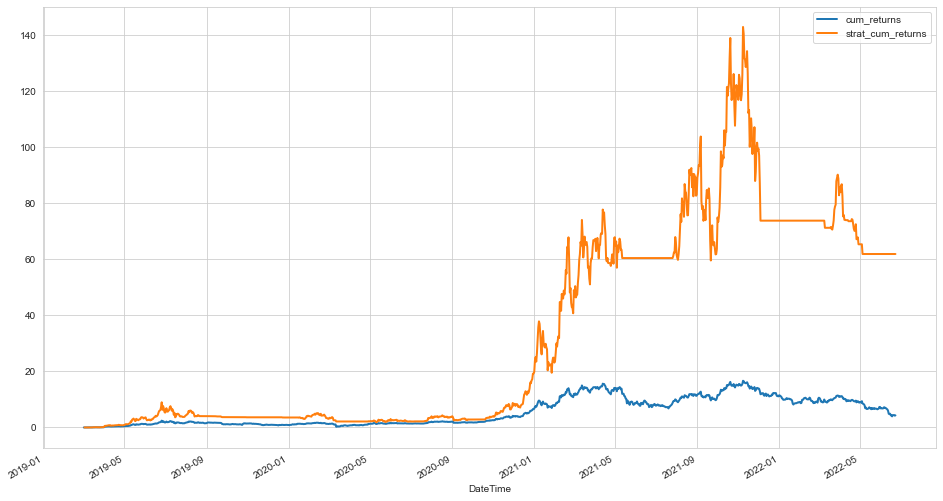

In [51]:
(df[['cum_returns', 'strat_cum_returns']].plot(lw=2, figsize=(16, 9)));

In [52]:
df['f'].describe()

count    1210.000000
mean        1.131977
std         0.951555
min         0.000000
25%         0.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: f, dtype: float64

## Kalman Kelly

In [53]:
kal = Kalman(ticker, interval=interval, price='Price_Returns')

In [54]:
start_df = df[:-1]

In [55]:
kal.update(start_df)

In [56]:
print(len(kal.state_mean))
kal.state_mean.iloc[-1]
kal.state_mean

1210


0                            0.000000
2019-03-02 00:00:00+00:00   -0.000404
2019-03-03 00:00:00+00:00   -0.001347
2019-03-04 00:00:00+00:00   -0.007278
2019-03-05 00:00:00+00:00    0.002380
                               ...   
2022-06-18 01:00:00+00:00   -0.028873
2022-06-19 01:00:00+00:00   -0.018088
2022-06-20 01:00:00+00:00   -0.016368
2022-06-21 01:00:00+00:00   -0.014119
2022-06-22 01:00:00+00:00   -0.016152
Name: BTCUSDT, Length: 1210, dtype: float64

In [57]:
kal.state_cov

0                            1.000000
2019-03-02 00:00:00+00:00    0.502488
2019-03-03 00:00:00+00:00    0.338838
2019-03-04 00:00:00+00:00    0.258621
2019-03-05 00:00:00+00:00    0.211742
                               ...   
2022-06-18 01:00:00+00:00    0.095125
2022-06-19 01:00:00+00:00    0.095125
2022-06-20 01:00:00+00:00    0.095125
2022-06-21 01:00:00+00:00    0.095125
2022-06-22 01:00:00+00:00    0.095125
Name: BTCUSDT, Length: 1210, dtype: float64

In [58]:
df['Kalman_mean'] = pd.Series(kal.state_mean)

In [59]:
df['Kalman_std'] = np.sqrt(kal.state_cov)

In [60]:
df

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60,f,kelly_returns,strat_cum_returns,cum_returns,Kalman_mean,Kalman_std
DateTime,,,,,,,,,,,,,,,
2019-03-02 00:00:00+00:00,3822.17,3841.31,3772.25,3819.93,19445.838355,2019-03-02 00:00:00+00:00,-0.000803,0.026616,0.000453,0.6568,NaN,NaN,-0.000803,-0.000404,0.708864
2019-03-03 00:00:00+00:00,3819.97,3835.00,3781.32,3807.75,16718.165410,2019-03-03 00:00:00+00:00,-0.003189,0.026540,0.000130,0.1900,-0.002094,-0.002094,-0.003989,-0.001347,0.582098
2019-03-04 00:00:00+00:00,3807.32,3830.00,3670.69,3715.30,34742.841660,2019-03-04 00:00:00+00:00,-0.024279,0.026547,0.000122,0.1780,-0.004613,-0.006698,-0.028172,-0.007278,0.508548
2019-03-05 00:00:00+00:00,3716.10,3877.10,3703.55,3857.73,32962.536162,2019-03-05 00:00:00+00:00,0.038336,0.026991,0.000649,0.9154,0.006824,0.000080,0.009084,0.002380,0.460155
2019-03-06 00:00:00+00:00,3857.58,3907.00,3813.09,3861.84,24775.118830,2019-03-06 00:00:00+00:00,0.001065,0.026978,0.000760,1.0716,0.000975,0.001056,0.010160,0.002142,0.426025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.875950,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591,0.0000,0.000000,61.913520,4.381637,-0.018088,0.308423
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.941540,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237,0.0000,-0.000000,61.913520,4.381609,-0.016368,0.308423
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.074900,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799,0.0000,0.000000,61.913520,4.420748,-0.014119,0.308423


In [61]:
kal._update(df.index[-1], df['Price_Returns'].iloc[-1])

In [62]:
df['Kalman_mean'].iloc[-1] = kal.state_mean.iloc[-1]
df['Kalman_std'].iloc[-1] = np.sqrt(kal.state_cov.iloc[-1])

In [63]:
df.tail()

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60,f,kelly_returns,strat_cum_returns,cum_returns,Kalman_mean,Kalman_std
DateTime,,,,,,,,,,,,,,,
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.87595,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591,0.0,0.0,61.91352,4.381637,-0.018088,0.308423
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.94154,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237,0.0,-0.0,61.91352,4.381609,-0.016368,0.308423
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.07490,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799,0.0,0.0,61.91352,4.420748,-0.014119,0.308423
2022-06-22 01:00:00+00:00,20723.51,20900.00,19770.51,19987.99,92133.97938,2022-06-22 01:00:00+00:00,-0.035493,0.044048,-0.010278,0.0,-0.0,61.91352,4.228352,-0.016152,0.308423
2022-06-23 01:00:00+00:00,19988.00,20829.21,19890.07,20299.85,55855.88533,2022-06-23 01:00:00+00:00,0.015602,0.044155,-0.010022,0.0,0.0,61.91352,4.309927,-0.013131,0.308423


In [65]:
df['kf'] = apply_kelly(df['Kalman_mean'].to_numpy(), df['Std_60'].to_numpy(), bounds=np.array([0., 1.]))

In [66]:
df = df.assign(kal_kelly_returns=df['Price_Returns'].mul(df['kf'].shift()))
df = df.assign(kal_kelly_cum_returns=df['kal_kelly_returns'].iloc[0:].add(1).cumprod().sub(1))

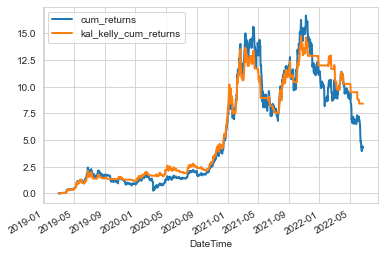

In [68]:
(df[['cum_returns', 'kal_kelly_cum_returns']].plot(lw=2));

In [69]:
df.tail()

,open,high,low,close,volume,time,Price_Returns,Std_60,SMA_60,f,kelly_returns,strat_cum_returns,cum_returns,Kalman_mean,Kalman_std,kf,kal_kelly_returns,kal_kelly_cum_returns
DateTime,,,,,,,,,,,,,,,,,,
2022-06-19 01:00:00+00:00,18970.79,20815.95,17960.41,20574.00,128320.87595,2022-06-19 01:00:00+00:00,0.084509,0.043885,-0.010591,0.0,0.0,61.91352,4.381637,-0.018088,0.308423,0.000006,5.037488e-07,8.415598
2022-06-20 01:00:00+00:00,20574.00,21090.00,19637.03,20573.89,109028.94154,2022-06-20 01:00:00+00:00,-0.000005,0.043883,-0.010237,0.0,-0.0,61.91352,4.381609,-0.016368,0.308423,0.000006,-3.187006e-11,8.415598
2022-06-21 01:00:00+00:00,20573.90,21723.00,20348.40,20723.52,104371.07490,2022-06-21 01:00:00+00:00,0.007273,0.043925,-0.009799,0.0,0.0,61.91352,4.420748,-0.014119,0.308423,0.000006,4.335221e-08,8.415598
2022-06-22 01:00:00+00:00,20723.51,20900.00,19770.51,19987.99,92133.97938,2022-06-22 01:00:00+00:00,-0.035493,0.044048,-0.010278,0.0,-0.0,61.91352,4.228352,-0.016152,0.308423,0.000006,-2.115660e-07,8.415596
2022-06-23 01:00:00+00:00,19988.00,20829.21,19890.07,20299.85,55855.88533,2022-06-23 01:00:00+00:00,0.015602,0.044155,-0.010022,0.0,0.0,61.91352,4.309927,-0.013131,0.308423,0.000006,9.300355e-08,8.415597


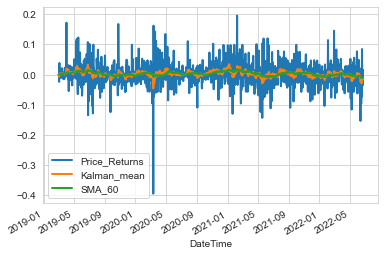

In [70]:
(df[['Price_Returns', 'Kalman_mean', 'SMA_60']].plot(lw=2));

### MAD

In [71]:
mad = lambda x: np.fabs(x - x.mean()).mean()

df['MAD'] = df['Price_Returns'].rolling(window=60).apply(mad, raw=True)
df[['MAD', 'Std_60']].tail()

,MAD,Std_60
DateTime,,
2022-06-19 01:00:00+00:00,0.033041,0.043885
2022-06-20 01:00:00+00:00,0.033005,0.043883
2022-06-21 01:00:00+00:00,0.033091,0.043925
2022-06-22 01:00:00+00:00,0.033516,0.044048
2022-06-23 01:00:00+00:00,0.033747,0.044155


In [73]:
df['mkf'] = apply_kelly(df['Kalman_mean'].to_numpy(), df['MAD'].to_numpy(), bounds=np.array([0., 1.]))

In [74]:
df = df.assign(mad_kal_kelly_returns=df['Price_Returns'].mul(df['mkf'].shift()))
df = df.assign(mad_kal_kelly_cum_returns=df['mad_kal_kelly_returns'].iloc[0:].add(1).cumprod().sub(1))

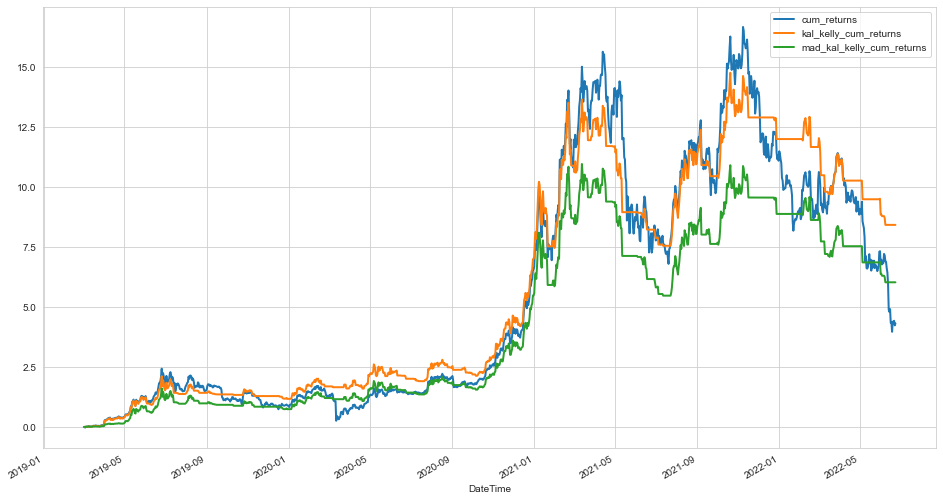

In [76]:
(df[['cum_returns', 'kal_kelly_cum_returns', 'mad_kal_kelly_cum_returns']].plot(lw=2, figsize=(16,9)));

In [77]:
df['mf'] = apply_kelly(df['SMA_60'].to_numpy(), df['MAD'].to_numpy(), bounds=np.array([0., 1.]))

In [78]:
df = df.assign(mad_kelly_returns=df['Price_Returns'].mul(df['mf'].shift()))
df = df.assign(mad_kelly_cum_returns=df['mad_kelly_returns'].iloc[0:].add(1).cumprod().sub(1))

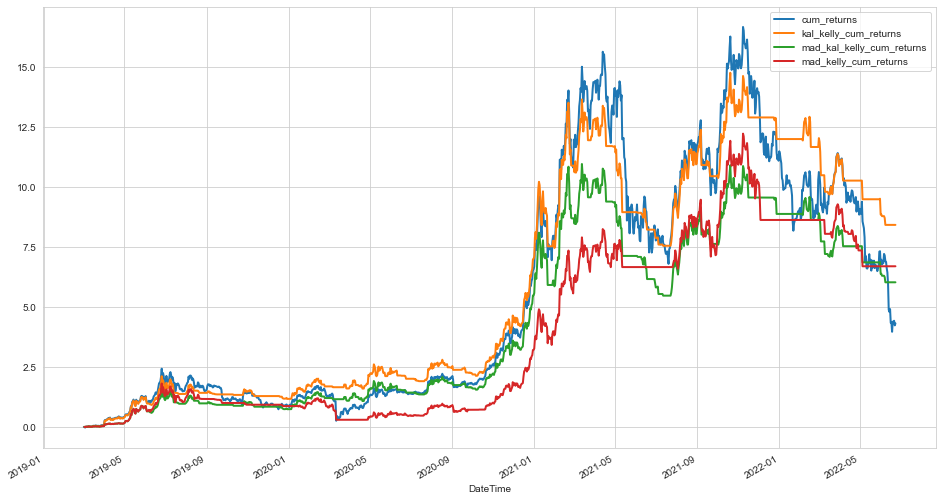

In [80]:
(df[['cum_returns', 'kal_kelly_cum_returns', 'mad_kal_kelly_cum_returns', 'mad_kelly_cum_returns']].plot(lw=2, figsize=(16, 9)));